<a href="https://colab.research.google.com/github/alexrods/Leon_Housing_Rent_prices/blob/main/Le%C3%B3n_Housing_Rent_Prices_Linear_Regression_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# León Housing Rent

This analysis collect data from [scrap housing](https://github.com/alexrods/Housing_scrapperML), with finality to put in action **Data Cleaning** and **Machine Learning** knowledge with **Linear Regression** and **Clustering** models

# Data Cleaning

In this first process of cleaning, i'll erase columns with less information and rows with extreme outliers. Later for each model i´ll prepare the data for it.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

Assign to the variable **data** the dataset and first look on

In [ ]:
#data = df
data = pd.read_csv('data_houses.csv')

data.head(3)

,Unnamed: 0,Superficie total,Superficie construida,Recámaras,Baños,Estacionamientos,Cantidad de pisos,Antigüedad,Orientación,Precio,URl,ubicacion,Ambientes,Tipo de propiedad,Cuota mensual de mantenimiento,Tipo de casa,Bodegas
0,0,74 m²,94 m²,3.0,3.0,1.0,2.0,2 años,Norte,"6,500",https://casa.mercadolibre.com.mx/MLM-930715722...,https://maps.googleapis.com/maps/api/staticmap...,NaN,NaN,NaN,NaN,NaN
1,0,75 m²,75 m²,3.0,2.0,1.0,2.0,8 años,Sur,"6,000",https://casa.mercadolibre.com.mx/MLM-940792537...,https://maps.googleapis.com/maps/api/staticmap...,NaN,NaN,NaN,NaN,NaN
2,0,200 m²,140 m²,3.0,2.0,2.0,2.0,6 años,NaN,"21,000",https://casa.mercadolibre.com.mx/MLM-911097958...,https://maps.googleapis.com/maps/api/staticmap...,NaN,NaN,NaN,NaN,NaN


### Cleaning columns with numerical data mixed with string data

I see string type data as 'm²', 'años' and ' , ', i proceed  replace with blank spaces and the coma's and chage to float type data

In [ ]:
# change columns data object type to float

data['Superficie total'] = data['Superficie total'].str.replace('m²', '').astype(float)
data['Superficie construida'] = data['Superficie construida'].str.replace('m²', '').astype(float)
data['Precio'] = data['Precio'].str.replace(',', '').astype(float)
data['Antigüedad'] = data['Antigüedad'].str.replace('años', '').astype(float)

In [ ]:
data.dtypes

Unnamed: 0                          int64
Superficie total                  float64
Superficie construida             float64
Recámaras                         float64
Baños                             float64
Estacionamientos                  float64
Cantidad de pisos                 float64
Antigüedad                        float64
Orientación                        object
Precio                            float64
URl                                object
ubicacion                          object
Ambientes                         float64
Tipo de propiedad                  object
Cuota mensual de mantenimiento     object
Tipo de casa                       object
Bodegas                           float64
dtype: object

### Add new columns for analysis and clean 

I want include geografical data, this are Latitude an Longitude, using regex i extract this fields from the 'ubicacion' column 

In [ ]:
# separate lat-lon

lat = []
lon = []
patron_location = re.compile('center=(\d*\.\d{3,8})\%\w*(\-?\d*\.\d{3,8})')
for coord in data['ubicacion']:
    try:
        location_str = patron_location.search(coord)
        lat.append(float(location_str.group(1)))
        lon.append(float(location_str.group(2)))
    except:
        print('No pude', coord)

data['Lat'] = lat
data['Lon'] = lon

Add this column helps to clean duplicated calues

In [ ]:
# add description on table

description_list = []
patron_description = re.compile('-(\d{9,10}-[\w*-]*)\_JM')
for url in data['URl']:
    try:
        description_match = patron_description.search(url)
        description_list.append(description_match.group(1))
    except:
        print("Aqui no pude ", url)

data['Description'] = description_list

### Processing outliers

A fast explore of the data with histplot

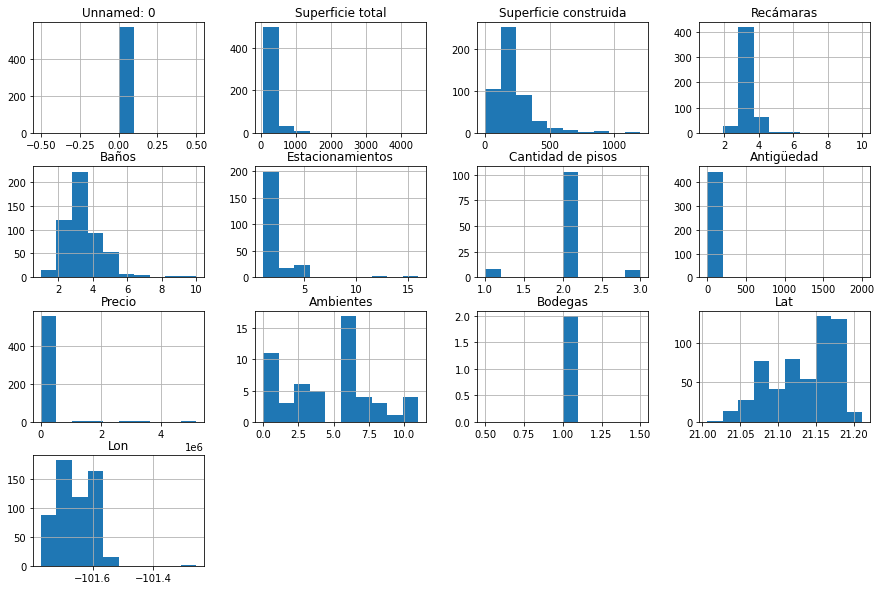

In [ ]:
data.hist(figsize=(15,10))
plt.show()

I can see ouliers in column "Precio"  present values up to 1M, this values are own of sales not for rent

"Antigüedad" present outliers too, old houses are usually for comercial use 

In [ ]:
data.drop(data[data['Precio'] > 100000.0].index, inplace=True)
data.drop(data[data['Antigüedad'] >= 100].index, inplace=True)

# Data with surface = 1, can represent problems for the model
data.drop(data[data['Superficie construida'] == 1].index, inplace=True)

# This sentece drop duplicate values
data.drop_duplicates(subset=['Description'], inplace=True)

### Processing Na values

In [ ]:
for col in data.columns:
    print(data[col].isna().value_counts()/len(data), col)

False    1.0
Name: Unnamed: 0, dtype: float64 Unnamed: 0
False    0.95933
True     0.04067
Name: Superficie total, dtype: float64 Superficie total
False    0.894737
True     0.105263
Name: Superficie construida, dtype: float64 Superficie construida
False    0.921053
True     0.078947
Name: Recámaras, dtype: float64 Recámaras
False    0.923445
True     0.076555
Name: Baños, dtype: float64 Baños
True     0.566986
False    0.433014
Name: Estacionamientos, dtype: float64 Estacionamientos
True     0.787081
False    0.212919
Name: Cantidad de pisos, dtype: float64 Cantidad de pisos
False    0.782297
True     0.217703
Name: Antigüedad, dtype: float64 Antigüedad
True     0.961722
False    0.038278
Name: Orientación, dtype: float64 Orientación
False    1.0
Name: Precio, dtype: float64 Precio
False    1.0
Name: URl, dtype: float64 URl
False    1.0
Name: ubicacion, dtype: float64 ubicacion
True     0.921053
False    0.078947
Name: Ambientes, dtype: float64 Ambientes
True     0.971292
False    0.0

Looking for missing values, evaluate the rate of na`s, close to 1 more na values, i'll erase values with ratio bigger than 0.5 

In [ ]:
data.drop(['Unnamed: 0', 'Orientación', 'Ambientes', 'Tipo de propiedad', 'Cuota mensual de mantenimiento', 
           'Tipo de casa', 'Bodegas', 'ubicacion', 'Cantidad de pisos', 'Description'], axis=1, inplace=True)

# Na values in 'Superficie total', 'Recámaras', 'Superficie construida' columns are hard to deduce 
data.dropna(axis=0, subset=['Superficie total', 'Recámaras', 'Superficie construida'], inplace=True)


Next to drop columns with large amount of missing values, the remaining columns will fill with the median of each column.

In [ ]:
for col in data.columns:
    try:
        data[col].fillna(data[col].median(), inplace=True)
    except Exception as e:
        print('Non numerical column', e)        
        

Non numerical column 


Now, to verify, dataset don't have missing values

In [ ]:
# search columns with elements na

for col in data.columns:
    print(data[col].isna().value_counts()/len(data), col)

False    1.0
Name: Superficie total, dtype: float64 Superficie total
False    1.0
Name: Superficie construida, dtype: float64 Superficie construida
False    1.0
Name: Recámaras, dtype: float64 Recámaras
False    1.0
Name: Baños, dtype: float64 Baños
False    1.0
Name: Estacionamientos, dtype: float64 Estacionamientos
False    1.0
Name: Antigüedad, dtype: float64 Antigüedad
False    1.0
Name: Precio, dtype: float64 Precio
False    1.0
Name: URl, dtype: float64 URl
False    1.0
Name: Lat, dtype: float64 Lat
False    1.0
Name: Lon, dtype: float64 Lon


Plotting the data clean this gets better

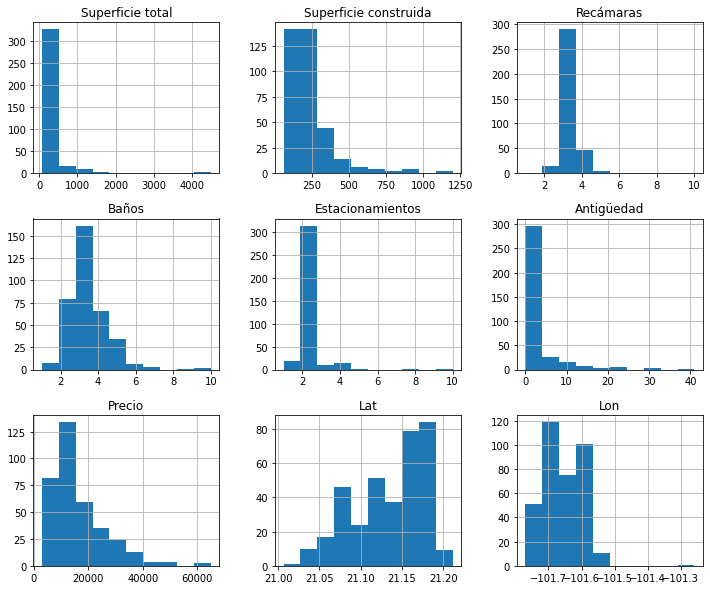

In [ ]:
data.hist(figsize=(12,10))
plt.show()

Finally reset index and check the types of columns be correctly, "URl" column survive, because i'll use it in one model

In [ ]:
data = data.reset_index()

In [ ]:
data.dtypes

index                      int64
Superficie total         float64
Superficie construida    float64
Recámaras                float64
Baños                    float64
Estacionamientos         float64
Antigüedad               float64
Precio                   float64
URl                       object
Lat                      float64
Lon                      float64
dtype: object

In [ ]:
#data.plot(kind='scatter', x='Lon', y='Lat', c='Precio', cmap=plt.get_cmap("jet"), colorbar=True, alpha=0.8, figsize=(15,8))

# Models

##  Predict rent prices



In this process i´ll make predictions of houses´s rent prices.

 I´ll use **tanh(x/a)** function for scale the data and i´ll use different models of linear regression until find the best score. 

### Preparing the Data for Regression

#### Feature engineering

In [ ]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

First assign the dataframe cleaned in the previous section "Data Cleaning" to the variable **data_cleaned** and create the new feature **Bathrooms_per_room**.

In [ ]:
data_predict = data.drop(['index', 'URl'], axis=1)
data_predict['Bathrooms_per_room'] = data_predict['Baños'] / data_predict['Recámaras']
data_predict.head(4)

,Superficie total,Superficie construida,Recámaras,Baños,Estacionamientos,Antigüedad,Precio,Lat,Lon,Bathrooms_per_room
0,74.0,94.0,3.0,3.0,1.0,2.0,6500.0,21.069286,-101.562949,1.000000
1,75.0,75.0,3.0,2.0,1.0,8.0,6000.0,21.171733,-101.649652,0.666667
2,200.0,140.0,3.0,2.0,2.0,6.0,21000.0,21.112184,-101.639459,0.666667
3,315.0,230.0,4.0,3.0,4.0,11.0,15000.0,21.099684,-101.639610,0.750000


Have a look to the correlation between the **Price** and the others features

In [ ]:
corr_matrix = data_predict.corr()
corr_matrix['Precio'].sort_values(ascending=False)

Precio                   1.000000
Superficie construida    0.783112
Baños                    0.620876
Superficie total         0.594126
Bathrooms_per_room       0.520066
Estacionamientos         0.270805
Recámaras                0.265040
Lat                      0.225736
Antigüedad              -0.033508
Lon                     -0.223897
Name: Precio, dtype: float64

#### Scalate features

Before to separate in train and test the data, i´ll scale the total dataframe and have a look to it´s distribution.

This is the function for scale the data:

$$
featureScaled = tanh\left(\frac{feature}{mean(feature)}\right)
$$



In [ ]:
data_scale_view = data_predict.copy()

In [ ]:
# scale function 

try:
    for col in data_scale_view.columns:
        data_scale_view[col] = np.tanh(data_scale_view[col] / np.mean(data_scale_view[col]))
except Exception as e:
    print(e, col)

In [ ]:
data_scale_view.head(5)

,Superficie total,Superficie construida,Recámaras,Baños,Estacionamientos,Antigüedad,Precio,Lat,Lon,Bathrooms_per_room
0,0.271107,0.384322,0.740364,0.727163,0.442070,0.674136,0.371940,0.760295,0.761198,0.746260
1,0.274585,0.312429,0.740364,0.547721,0.442070,0.997133,0.345760,0.762333,0.761556,0.566921
2,0.636049,0.539444,0.740364,0.547721,0.739603,0.985359,0.851662,0.761150,0.761514,0.566921
3,0.828592,0.757896,0.853358,0.727163,0.956169,0.999753,0.717052,0.760901,0.761515,0.618978
4,0.537909,0.775647,0.740364,0.727163,0.739603,0.000000,0.745014,0.761362,0.761441,0.746260


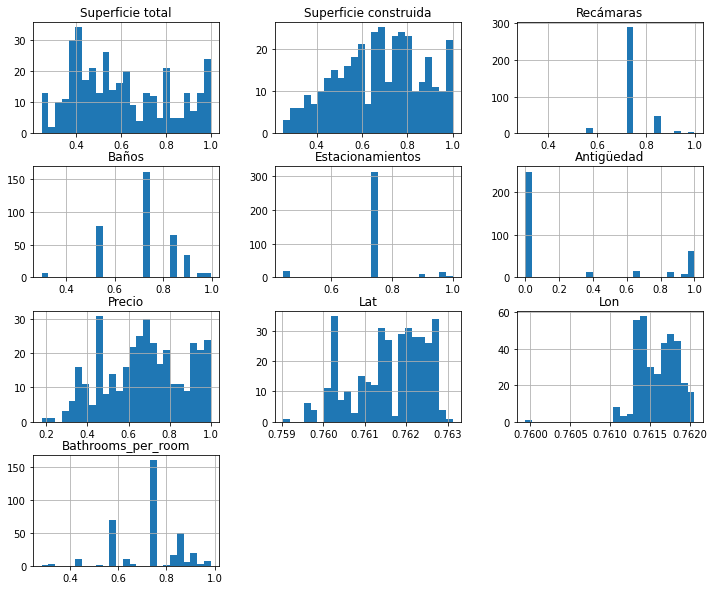

In [ ]:
data_scale_view.hist(bins=25, figsize=(12,10))
plt.show()

This isn´t nice, don´t show a normal or uniform distribution,  but i´ll try it.

Now i procced to separate in train, test dataframe, and scale using the $tanh(x/a)$ function

In [ ]:
X = data_predict.drop(['Precio'], axis=1)
y = data_predict['Precio']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#### Scale with tanh function

In [ ]:
# I keep the original train-test data for rescale the final result

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
y_train_scaled = y_train.copy()
y_test_scaled = y_test.copy()

In [ ]:
# scale train data

for col in X_train_scaled.columns:
        X_train_scaled[col] = np.tanh(X_train_scaled[col] / np.mean(X_train_scaled[col]))

y_train_scaled = np.tanh(y_train_scaled / np.mean(y_train_scaled))

In [ ]:
# scale test data

for col in X_test_scaled.columns:
        X_test_scaled[col] = np.tanh(X_test_scaled[col] / np.mean(X_test_scaled[col]))
y_test_scaled = np.tanh(y_test_scaled / np.mean(y_test_scaled))

For compare the method i'll compare with this others scaler

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

#### Scale with StandarScaler

In [ ]:
standar_scaler = StandardScaler()

X_train_standar = standar_scaler.fit_transform(X_train)
#y_train_standar = standar_scaler.fit_transform(y_train.to_numpy().reshape(-1,1))
X_test_standar = standar_scaler.fit_transform(X_test)
#y_test_standar = standar_scaler.fit_transform(y_test.to_numpy().reshape(-1,1))

#### Scale with MinMaxScaler

In [ ]:
min_max = MinMaxScaler()

X_train_minmax = min_max.fit_transform(X_train)
#y_train_minmax= min_max.fit_transform(y_train.to_numpy().reshape(-1,1))
X_test_minmax = min_max.fit_transform(X_test)
#y_test_minmax = min_max.fit_transform(y_test.to_numpy().reshape(-1,1))

#### Scale with RobustScaler

In [ ]:
robust = RobustScaler()

X_train_robust = robust.fit_transform(X_train)
#y_train_robust = robust.fit_transform(y_train.to_numpy().reshape(-1,1))
X_test_robust = robust.fit_transform(X_test)
#y_test_robust = robust.fit_transform(y_test.to_numpy().reshape(-1,1))

#### Scale with PowerTransform

In [ ]:
pt = PowerTransformer()

X_train_power = pt.fit_transform(X_train)
#y_train_power = pt.fit_transform(y_train.to_numpy().reshape(-1,1))
X_test_power = pt.fit_transform(X_test)
#y_test_power = pt.fit_transform(y_test.to_numpy().reshape(-1,1))                                 

### Machine Learning model

In [ ]:
# import methods to make Linear Regression

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 

# for compute the error
from sklearn.metrics import mean_squared_error

I create a function for evaluate each method, this return a dict with the best score

In [ ]:
def data_evaluation(x_train, x_test, y_train, y_test):
    if type(x_train) != np.ndarray:
        x_train = x_train.to_numpy()
        x_test = x_test.to_numpy()
        y_train = y_train.to_numpy().reshape(-1,1)
        y_test = y_test.to_numpy().reshape(-1,1)
   
    models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
    error_results = []
    for model in models:
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        error = np.sqrt(mean_squared_error(y_test, predictions))
        error_results.append({"model": model,
                              "error": error})
    sorted_values = sorted(error_results, key= lambda k:k['error'])
    best_score = sorted_values[0]

    return best_score

In [ ]:
# evaluate the model with the different scales

error_predict_tanh_scale = data_evaluation(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)
error_predict_standar_scale = data_evaluation(X_train_standar, X_test_standar, y_train, y_test)
error_predict_minmax_scale = data_evaluation(X_train_minmax, X_test_minmax, y_train, y_test)
error_predict_robust_scale = data_evaluation(X_train_robust, X_test_robust, y_train, y_test)
error_predict_power_scale = data_evaluation(X_train_power, X_test_power, y_train, y_test)

In [ ]:
print(f'''Tanh mse: {error_predict_tanh_scale}\n\nStandarScale rmse: {error_predict_standar_scale}\n\n
MinMaxScale rmse: {error_predict_minmax_scale}\n\nRobustScale rmse: {error_predict_robust_scale}\n\n
PowerTransform rmse: {error_predict_power_scale}''')

Tanh mse: {'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), 'error': 0.10015923680839917}

StandarScale rmse: {'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), 'error': 5187.789311860717}


MinMaxScale rmse: {'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), 'error': 5199.789398472337}

RobustScale rmse: {'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), 'error': 5743.220758964819}


PowerTransform rmse: {'model': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=

### Results

For represent the result on original scale, use:

$$
original Value = arctanh(scaledValue) * mean(feature["Precio"]) 
$$

In [ ]:
# Rescale of rmse
# the scale methods have the *inverse_transform* class

print("StandarScaler rescaled rmse: ", error_predict_standar_scale['error'])
print("\nMinMaxScaler  rescaled rmse: ", error_predict_minmax_scale['error'])
print("\nRobustScaler  rescaled rmse:", error_predict_robust_scale['error'])
print("\nPowerScaler   rescaled rmse:", error_predict_power_scale['error'])

# for rescale the tanh scale, i make the inverse process

print("\nTanhScaler    rescaled rmse: ", np.arctanh(error_predict_tanh_scale['error']) * np.mean(y_test))

StandarScaler rescaled rmse:  5187.789311860717

MinMaxScaler  rescaled rmse:  5199.789398472337

RobustScaler  rescaled rmse: 5743.220758964819

PowerScaler   rescaled rmse: 5808.7922358079095

TanhScaler    rescaled rmse:  1671.0981966515744


## Clustering

In this section i'll classify the houses using kmeans method.

First i'll clean categorical data, columns "index" and "URl"

### Data preparation

In [ ]:
data_cluster = data.drop(['index' ,'URl'], axis=1)

In this case i transform the data with tanh(x) function for use in the model

In [ ]:
# scale function 

data_transform = data_cluster.copy()
for col in data_transform.columns:
    data_transform[col] = np.tanh(data_transform[col] / np.mean(data_transform[col]))


###  Chooose optimal *n-clusters*

In [ ]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# kmeans function

def kmeans_classificator(data, clusters):
    kmeans = MiniBatchKMeans(n_clusters=clusters, batch_size=50)
    data_kmeans = kmeans.fit(data)
    inertia = data_kmeans.inertia_
    return data_kmeans, inertia

I'll calculate kmeans algorithm in a range 1 to 10, and so, choose the optimal n-cluster number.

In [ ]:
nclusters = []
inertia = []
classifications = []
for n in range(1, 10):
    kmeans = kmeans_classificator(data_transform, n)
    nclusters.append(n)
    classifications.append(kmeans[0])
    inertia.append(kmeans[1])

Using the "elbow" method, i'll plot the inertia of each clasification

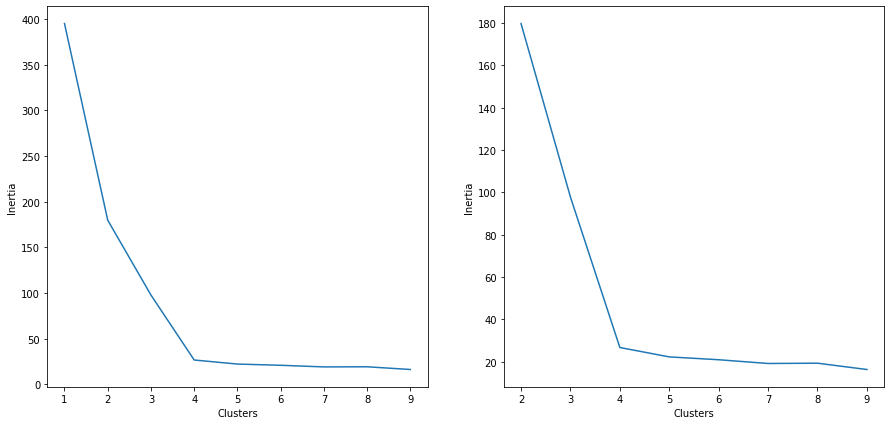

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,7))
axs[0].plot(nclusters, inertia)
axs[1].plot(nclusters[1:], inertia[1:])
for i in range(2):
    axs[i].set_xlabel('Clusters')
    axs[i].set_ylabel('Inertia')
plt.show()


Supported by "elbow" method  the conclusion is: 

I'll take 4 clusters for classification

In [ ]:
# Add the labels of class on dataframe

data_transform['clase'] = classifications[3].labels_

In [ ]:
# Looking for the size of classes

data_transform['clase'].value_counts()

1    163
2     97
0     53
3     45
Name: clase, dtype: int64

Have a look of the class distribution with a pairplot

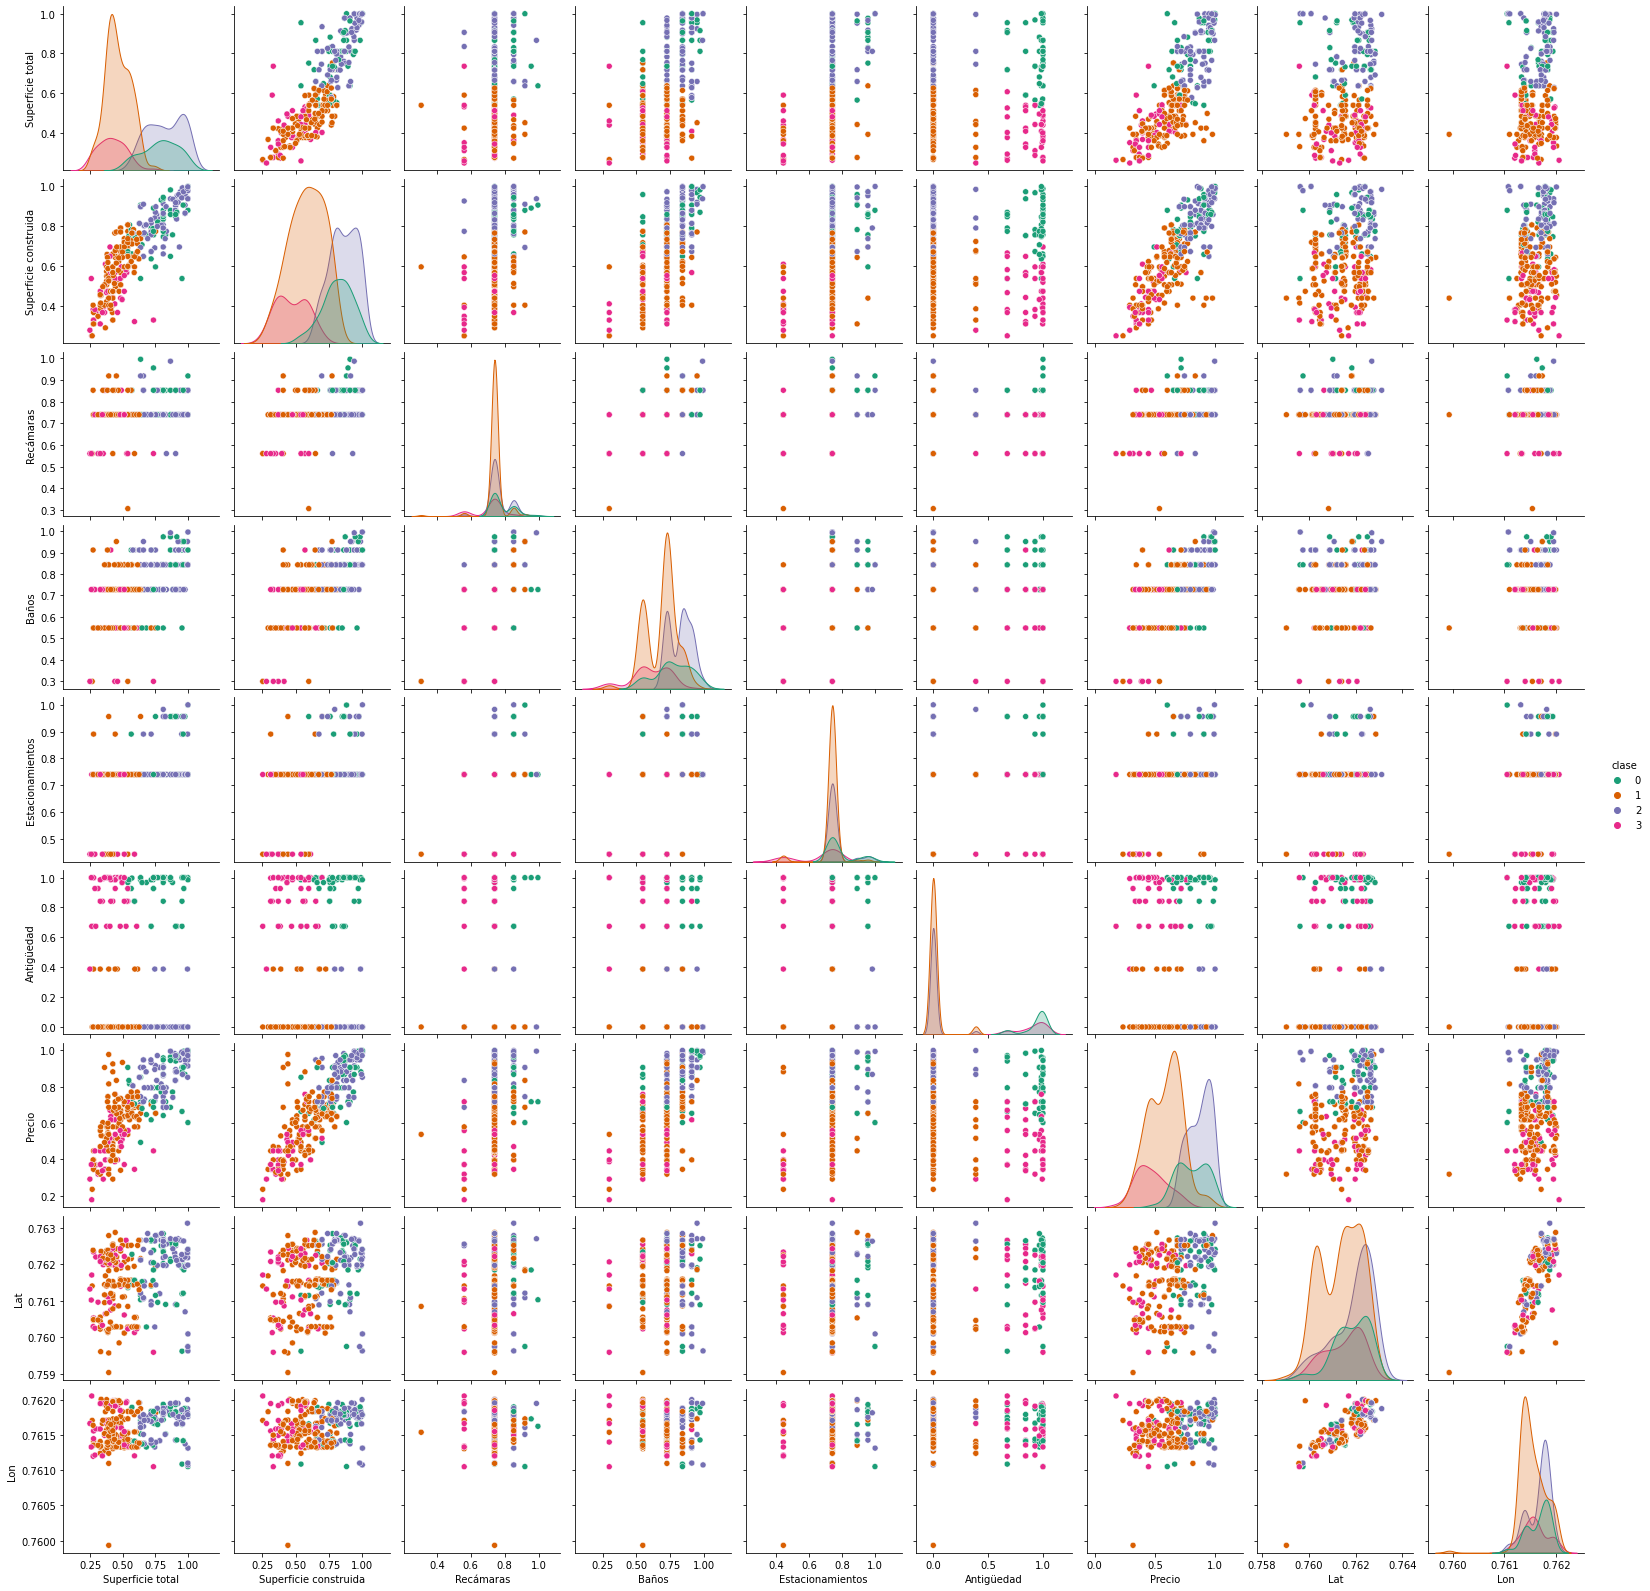

In [ ]:
sns.pairplot(data_transform, hue='clase', palette='Dark2', )
plt.legend()

Here i use a discretizer for norlmalize the data in a range between 1 to 5 

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

In [ ]:
# Here i drop the column "clase" for later append to the dataframe discretized

data_to_disc = data_transform.drop(['clase'], axis=1)
clases = data_transform[['clase']]

In [ ]:
# define the discretizer arguments

discretizer = KBinsDiscretizer(n_bins=5, strategy='uniform', encode='ordinal')
data_disc = discretizer.fit_transform(data_to_disc)
df_data_disc = pd.DataFrame(data_disc, columns=data_to_disc.columns)

In [ ]:
# concat discretized dataframe with the class column
df_data_disc = pd.concat([df_data_disc, clases], axis=1)

### Radar Chart

For visualize the characteristics of each class, i'will represent with *radar chart*

In [ ]:
# i group the data by "clase" and calculate the mean of each characteristic

df_for_radar = df_data_disc.groupby(['clase']).mean()

In [ ]:
# list of the characteristics names

categories = list(df_data_disc.drop(['clase'], axis=1).columns)
categories

['Superficie total',
 'Superficie construida',
 'Recámaras',
 'Baños',
 'Estacionamientos',
 'Antigüedad',
 'Precio',
 'Lat',
 'Lon']

I create a function for plot the graphs

In [ ]:
def plot_radar_chart(data_plot, n_images=None):
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories)+1).tolist()
    df_plot = data_plot.tolist()
    df_plot += df_plot[:1]

    plt.figure(figsize=(5,5))
    plt.subplot(polar=True)
    plt.plot(label_loc, df_plot)
    plt.fill(label_loc, df_plot, 'b', alpha=0.1)
    plt.yticks([1, 2, 3, 4, 5], ["1", "2", "3", "4", "5"])
    plt.title(f'Characteristics group {n_images}\n', size=20)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
       
    return plt.show()

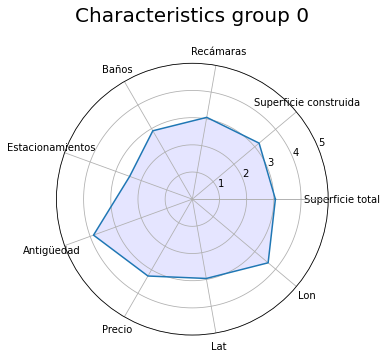

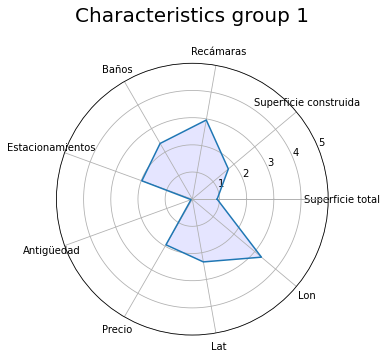

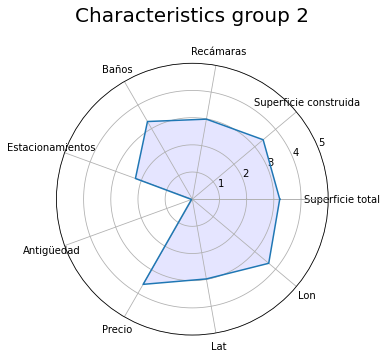

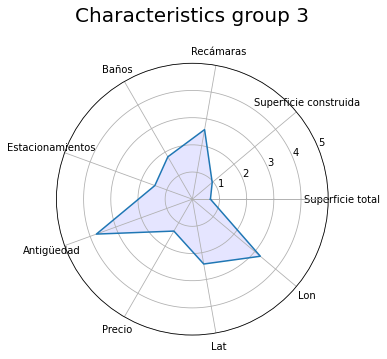

In [ ]:
for i in range(len(df_for_radar)):
    plot_radar_chart(df_for_radar.loc[i], i)

Now visualize  the distribution in a map of the original data with the label of classes

In [ ]:
data_cluster['clase'] = classifications[3].labels_

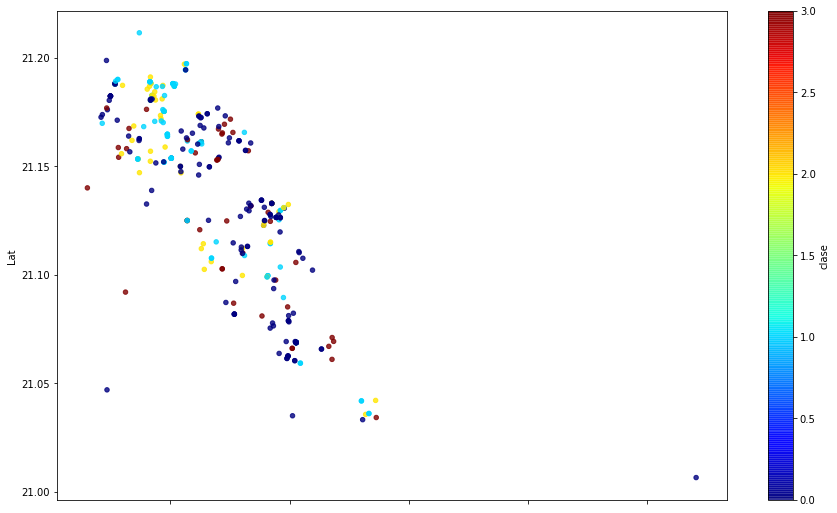

In [ ]:
data_cluster.plot(kind='scatter', x='Lon', y='Lat', c='clase', cmap=plt.get_cmap("jet"), alpha=0.8, figsize=(15,9))


This image conclude that, in all the city have distribute houses of all classes.